# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
# import libraries
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from time import time

In [ ]:
# load the dataset 
df = spark.read.json('/mini_sparkify_event_data.json')
# check the schema of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [ ]:
print('The dataset has {} rows.'.format(df.count()))

The dataset has 286500 rows.


In [ ]:
df.select(min(to_timestamp(col('ts')/1000)).alias('Start time')).show()

+-------------------+
|         Start time|
+-------------------+
|2018-10-01 00:01:57|
+-------------------+



In [ ]:
df.select(max(to_timestamp(col('ts')/1000)).alias('End time')).show()

+-------------------+
|           End time|
+-------------------+
|2018-12-03 01:11:16|
+-------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
display(df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
display(df.select("page").distinct())

page
Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About


### Define the Churn Column by the flag == "Cancellation Confirmation"

In [ ]:
# Define the function to check if page be cancellation or not
cancellation_check_function = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# Applied and generated new columns named churn
df = df.withColumn("churn", cancellation_check_function("page"))

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, sum as Fsum

# Define the window bounds to use Fsum to count for the churn
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Apply the window function to the DataFrame df
df = df.withColumn("churn", Fsum(col("churn")).over(windowval))

# Calculate the sum of the "churn" column
# Display the result
#num_churn = df.select('userId','churn').distinct().agg(Fsum("churn"))
#print('The total number of churners is:', num_churn.show())

In [ ]:
def missing_values(df, col):
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

print("\n[Missing values]\n")
for col in df.columns:
    missing_count = missing_values(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))


[Missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [ ]:
df = df.filter(df["userId"] != "")
df.count()

Out[11]: 278154

## Exploratory Data Analysis (EDA)

#### 1. Numerical EDA

#### 1.1 Rate within female and males category:

In [ ]:
stat_df = spark.createDataFrame(df.dropDuplicates(['userId']).collect())
stat_df1 = stat_df[['gender', 'churn']]
print('The avg churn rate of females is:', stat_df1.groupby(['gender']).mean().collect()[0][1]*100)
print('The avg churn rate of males is:', stat_df1.groupby(['gender']).mean().collect()[1][1]*100)

The avg churn rate of females is: 19.230769230769234
The avg churn rate of males is: 26.446280991735538


#### 1.2 Viewing top 5 cancellations by artist

In [ ]:
stat_df1 = stat_df[['artist', 'churn']]
display(stat_df1.groupBy(['artist']).sum().orderBy('sum(churn)', ascending = False).collect()[:5])

artist,sum(churn)
null,27
Orenda Fink,1
P!nk,1
Gorillaz,1
Blake Shelton,1


#### 1.3 Rate for “paid” and “free” category:

In [ ]:
stat_df1 = stat_df[['level', 'churn']]
print('Proportion of users that chruned from free subscirption', stat_df1.groupBy(['level']).mean().collect()[0][1]*100)
print('Proportion of users that chruned from paid subscirption',stat_df1.groupBy(['level']).mean().collect()[1][1]*100)

Proportion of users that chruned from free subscirption 24.858757062146893
Proportion of users that chruned from paid subscirption 16.666666666666664


#### 1.4 Top 10 states category

In [ ]:
from pyspark.sql.functions import split, sum
from pyspark.sql import functions as F

stat_df1 = stat_df.select('location', 'churn')
stat_df1 = stat_df1.withColumn('state', split(stat_df1['location'], ',').getItem(1))
stat_df1 = stat_df1.drop('location')

print('Viewing top 10 states with churn:\n')
stat_df1.groupBy('state').agg(F.sum('churn').alias('total_churn')).filter('total_churn > 0').orderBy(F.desc('total_churn')).show(10)

Viewing top 10 states with churn:

+---------+-----------+
|    state|total_churn|
+---------+-----------+
|       CA|          6|
| NY-NJ-PA|          5|
|       MI|          3|
|       FL|          3|
|       TX|          3|
|       WA|          2|
|       OH|          2|
|       CO|          2|
|       KY|          2|
|       AZ|          2|
+---------+-----------+
only showing top 10 rows



#### 2. Time Analysis

In [ ]:
def get_series(col, value, normalize):
    # Function to retrieve series based on col, value, and normalization option
    if normalize:
        total_count = dfp[col].sum()  # Assuming dfp is the Pandas DataFrame containing the data

        if total_count > 0:
            series = dfp[dfp[col] == value][col].value_counts(normalize=True) * 100
        else:
            series = pd.Series()
    else:
        series = dfp[dfp[col] == value][col].value_counts()

    return series

In [ ]:
# Define UDFs and DataFrame transformations (as mentioned in your code)
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import datetime

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month, IntegerType())
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'), IntegerType())

# Usage of UDFs in DataFrame transformations
data = df.withColumn('hour', get_hour(df.ts))
data = data.withColumn('day', get_day(df.ts))
data = data.withColumn('month', get_month(df.ts))
data = data.withColumn('week_day', get_weekday(df.ts))
dfp = data.toPandas()

In [ ]:
def get_series(col, churn, normalize=False):
    ser1 = dfp[dfp.churn == churn].groupby([col])['userId'].count()
 
    try:
        ser1.index = ser1.index.astype(int)
    except:
        pass
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

##### (churn = 1) and non-churners(churn = 0) is needed.
##### Normalize Boolean
##### any title or rotation in plot if user wishes at all, just for visual analytics convenience.

In [ ]:
def draw_time(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    # Normalize to fit with 2 group of users
    df_time = pd.DataFrame({'Cancelled': get_series(col, 1, normalize),
                        'Active users':get_series(col, 0, normalize)})
 
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
 
    if title is None:
        title = col
 
    ax.set_ylabel(f'Percent of users')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
 
    return ax

#### Graph shows Churn and Non-churn by hour of the day:

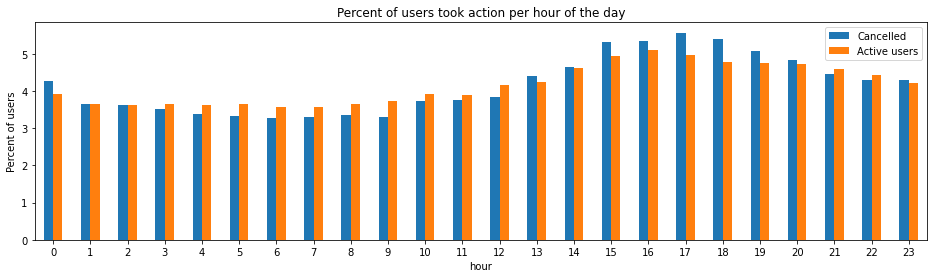

In [ ]:
draw_time('hour', title='hour of the day');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.
Subject Matter Expert, commonly abbreviated as SME

### Independent Variables:
#### 1.) Time Since Registration:

In [ ]:
from pyspark.sql.functions import col

feature_1 = data.select('userId', 'registration', 'ts') \
    .withColumn('lifetime', (data.ts - data.registration)) \
    .groupBy('userId') \
    .agg({'lifetime': 'max'}) \
    .withColumnRenamed('max(lifetime)', 'lifetime') \
    .select('userId', (col('lifetime') / 1000 / 3600 / 24).alias('lifetime'))

feature_1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|  79.84568348765428|
| stddev|105396.47791907165|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



#### 2.) Total Songs Listened:

In [ ]:
feature_2 = data \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
feature_2.describe().show()

+-------+------------------+------------------+
|summary|            userID|       total_songs|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|           1236.24|
| stddev|105396.47791907165|1329.5317164325188|
|    min|                10|                 6|
|    max|                99|              9632|
+-------+------------------+------------------+



#### 3.) Like of user:

In [ ]:
feature_3 = data \
    .select('userID','page') \
    .where(data.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up')
feature_3.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121884|65.67028650524043|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



#### 4.) Dislike of user: ( Check for Thumbs Down Page)

In [ ]:
feature_4 = data \
    .select('userID','page') \
    .where(data.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
feature_4.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893778|13.198108566983791|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



#### 5.) Playlist length: (Check for the Add to Playlist Page)

In [ ]:
feature_5 = data \
    .select('userID','page') \
    .where(data.page == 'Add to Playlist') \
    .groupBy('userID')\
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')
feature_5.describe().show()

+-------+-----------------+-----------------+
|summary|           userID|  add_to_playlist|
+-------+-----------------+-----------------+
|  count|              215|              215|
|   mean|66103.63720930232|30.35348837209302|
| stddev|106360.4799956504| 32.8520568555997|
|    min|               10|                1|
|    max|               99|              240|
+-------+-----------------+-----------------+



#### 6.) Referring friends: (Check for the Add Friend Page)

In [ ]:
feature_6 = data \
    .select('userID','page') \
    .where(data.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend')
feature_6.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405014|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



#### 7.) Listening Longevity: ( Check for the total listen time each user)

In [ ]:
feature_7 = data \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
feature_7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155558|
| stddev|105396.47791907165|275396.40388476395|
|    min|                10|         691.66884|
|    max|                99|1991154.9155800021|
+-------+------------------+------------------+



#### 8.) Songs per Session: (Avange song played per Sessions Count the number user hit NextSong group by sessionId, userId and take avarange of the number of song be played corresponding to that SessionID)

In [ ]:
feature_8 = data.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')

In [ ]:
display(feature_8)

In [ ]:
display(feature_8.describe())

#### 9.) Gender: (Replace M and F by 0 and 1)

In [ ]:
feature_9 = data \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))

In [ ]:
display(feature_9)

userId,gender
44,1
46,1
41,1
39,1
40,1
94,1
35,1
75,1
100,0
25,1


#### 10.) Number of Artists Listened: ( Count the total of Artists that each user listen to)

In [ ]:
feature_10 = data \
    .filter(data.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
display(feature_10)

userId,artist_count
100010,252
200002,339
125,8
51,1385
124,2232
7,142
15,1302
54,1744
155,643
132,1299


In [ ]:
display(feature_10.describe())

summary,userId,artist_count
count,225,225
mean,65391.013333333336,696.3777777777777
stddev,105396.47791907162,603.9518698630803
min,10,3
max,99,3544


#### Dependent Variable:
- Create a dependent variable from churn column
- Create numeric categories of churn label as 1 = churn and 0 = no churn.

In [ ]:
# Change the name of churn collumn to label and drop all duplicate in UserID columns
label_churn = data \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
display(label_churn)

userId,label
10,0
100,0
100001,1
100002,0
100003,1
100004,0
100005,1
100006,1
100007,1
100008,0


#### Construct the DataSet for AI

##### - Joint all the feature table and label table into dataframe with outer join based on userID and fillna with 0

In [ ]:
# Add columns to the dataframe to create a dataset fed the AI model 
data = feature_1.join(feature_2,'userID','outer') \
    .join(feature_3,'userID','outer') \
    .join(feature_4,'userID','outer') \
    .join(feature_5,'userID','outer') \
    .join(feature_6,'userID','outer') \
    .join(feature_7,'userID','outer') \
    .join(feature_8,'userID','outer') \
    .join(feature_9,'userID','outer') \
    .join(feature_10,'userID','outer') \
    .join(label_churn,'userID','outer') \
    .drop('userID') \
    .fillna(0)

In [ ]:
display(data)

lifetime,total_songs,num_thumb_up,num_thumb_down,add_to_playlist,add_friend,listen_time,avg_songs_played,gender,artist_count,label
51.76265046296297,795,37,4,9,12,166866.37251000004,112.16666666666667,0,565,0
64.87377314814815,3214,148,27,61,49,672877.8565899997,78.88235294117646,0,1705,0
44.80021990740741,187,8,2,3,2,35073.742150000005,33.25,1,125,1
160.47207175925925,218,5,0,5,1,49559.9181,48.75,1,184,0
22.748113425925926,78,3,0,2,0,12306.419320000003,25.5,1,50,1
172.44008101851853,1245,35,11,23,19,231480.3892899999,47.1,1,733,0
85.19559027777778,216,7,3,3,3,37037.12201000001,38.5,0,149,1
9.127164351851851,44,2,2,1,4,5854.89105,26.0,1,26,1
115.38761574074074,520,19,6,9,17,104495.32492000004,47.0,1,357,1
68.22856481481482,940,37,6,30,17,191396.79602,128.66666666666666,1,623,0


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Normalizing:

-  Turn to normalization of our features that will assurance any independent variable alone or few of them would not influence the dependent variable to an extent where other features become redundant.

In [ ]:
# Vector assembler
cols = ["lifetime", "total_songs", "num_thumb_up", 'num_thumb_down','add_to_playlist','add_friend','listen_time','avg_songs_played','gender','artist_count']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-982729752477018>:4
      2 cols = ["lifetime", "total_songs", "num_thumb_up", 'num_thumb_down','add_to_playlist','add_friend','listen_time','avg_songs_played','gender','artist_count']
      3 assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
----> 4 data = assembler.transform(data)

File /databricks/spark/python/pyspark/ml/base.py:262, in Transformer.transform(self, dataset, params)
    260         return self.copy(params)._transform(dataset)
    261     else:
--> 262         return self._transform(dataset)
    263 else:
    264     raise TypeError("Params must be a param map but got %s." % type(params))

File /databricks/spark/python/pyspark/ml/wrapper.py:400, in JavaTransformer._transform(self, dataset)
    397 assert self._java_obj is not None
    399 self._transfer_params_to_java()
--> 400 return Dat

#### Scaling:
- Substract the mean of each feature from every value of that feature and then divide it by standard deviation of each feature using withStd = True

In [ ]:
# standard scaler
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="NumFeatures",outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

#### Train - Validation — Test Dataset Split
 - Take 70% for TrainData
 - Take 18% for Validation
 - Take 12% for Test

 ** Note ** 
 The seed=42 parameter of randomSplit() ensures that same pseudorandom number is generated every-time by preserving the copy of first time generated pseudo number.

In [ ]:
# train test split
train, rest = data.randomSplit([0.7, 0.3], seed=42)
validation, test = rest.randomSplit([0.6, 0.4], seed=42)

## Base Model 
##### using MulticlassClassificationEvaluator to mesures how 0 label and 1 label are performing

In [ ]:
# Mesure label 0
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import lit

# Take the test dataset and create prediction column and filled with all 0 to test with the evaluator
test_set_base_0 = test.withColumn('prediction', lit(0.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Evaluate the dataset based all 0 for accuracy and f1 score
print('Accuracy: {}'.format(evaluator.evaluate(test_set_base_0, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(test_set_base_0, {evaluator.metricName: "f1"})))

Accuracy: 0.75
F1 Score:0.6428571428571428


In [ ]:
# Mesure label 1
# Take the test dataset and create prediction column and filled with all 0 to test with the evaluator
test_set_base_1 = test.withColumn('prediction', lit(1.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Evaluate the dataset based all 1 for accuracy and f1 score
print('Accuracy: {}'.format(evaluator.evaluate(test_set_base_1, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(test_set_base_1, {evaluator.metricName: "f1"})))

Accuracy: 0.25
F1 Score:0.1


## Logistic Regression Model

#### Initialize necessary values

In [ ]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')   # Based on f1 score

# build empty paramGrid
paramGrid = ParamGridBuilder().build()
crossval_lr = CrossValidator(estimator=lr, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3) # data will be split into three folds during cross-validation (numFolds=3)

In [ ]:
# Fit data to crossval_lr
FittedModel_lr = crossval_lr.fit(train)

# Take the List of result metrics 
FittedModel_lr.avgMetrics

# Transform the data and collect the result
results_lr = FittedModel_lr.transform(validation)

# Evaluate the data
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Logistic Regression Metrics Result')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.7
F-1 Score:0.6048237476808906


## Gradient Boosted Tree

#### Initialize necessary values

In [ ]:
# initialize classifier
GradBoostTree = GBTClassifier(maxIter=5,seed=42)
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1') # f1 score
# build paramGrid
paramGrid = ParamGridBuilder().build()
crossval_GradBoostTree = CrossValidator(estimator=GradBoostTree, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=5)

In [ ]:
# Fit data to crossval_GradBoostTree
FittedModel_GradBoostTree = crossval_GradBoostTree.fit(train)

# Take the List of result metrics 
FittedModel_GradBoostTree.avgMetrics

# Transform the data and collect the result
results_GradBoostTree = FittedModel_GradBoostTree.transform(validation)

# Evaluate the data
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_GradBoostTree, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_GradBoostTree, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.6
F1 Score:0.5681818181818181


## Test Deployment & Hyperparameter Tuning

In [ ]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
lr = LogisticRegression()

paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [10,12]).addGrid(lr.regParam, [0,0.1]).addGrid(lr.elasticNetParam, [0.001,0.01]).build()

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,evaluator=f1_evaluator, numFolds=3)

In [ ]:
lrModel = lr_cv.fit(train)
bestModel = lrModel.bestModel
results_final = bestModel.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:') 
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.78125
F-1 Score:0.741852487135506


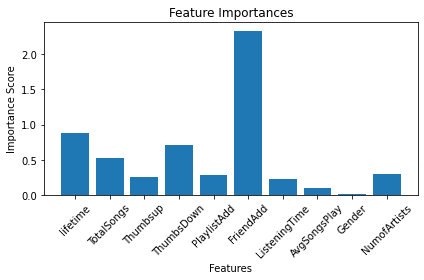

Feature Importances:
lifetime: 0.8869283166754653
TotalSongs: 0.5263335249712722
Thumbsup: 0.2637792562253803
ThumbsDown: 0.7113069882761516
PlaylistAdd: 0.280227366787711
FriendAdd: 2.3281389788995943
ListeningTime: 0.22512421092172308
AvgSongsPlay: 0.10008238735179366
Gender: 0.02210301307202979
NumofArtists: 0.2955938882996465


In [ ]:
import matplotlib.pyplot as plt

def calculate_feature_importances(coefficients, feature_names):
    feat_imp = [0 - x if x < 0 else x for x in coefficients]
    feature_importances = list(zip(feature_names, feat_imp))
    return feat_imp, feature_importances

feat_imp, feature_importances = calculate_feature_importances(bestModel.coefficients, cols)

# Plotting the vertical bar chart
plt.bar(cols, feat_imp, align='center')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')

plt.xticks(rotation=45) # Rotate to Vertical bar chart
plt.tight_layout()
plt.show()


In [ ]:
# Printing the table of feature importances
print('Feature Importances:')
for feature, importance in feature_importances:
    print(f'{feature}: {importance}')

Feature Importances:
lifetime: 0.8869283166754653
TotalSongs: 0.5263335249712722
Thumbsup: 0.2637792562253803
ThumbsDown: 0.7113069882761516
PlaylistAdd: 0.280227366787711
FriendAdd: 2.3281389788995943
ListeningTime: 0.22512421092172308
AvgSongsPlay: 0.10008238735179366
Gender: 0.02210301307202979
NumofArtists: 0.2955938882996465
